# Loading and working with processed paedal Visium data - post cell2location deconvolution

In [1]:
import numpy as np
import scipy as sp
import scanpy as sc
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import re
import os
import scipy.stats
from numpy import asarray as ar
from collections import Counter
import anndata as ad
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

from datetime import date
today = str(date.today())
sc.settings.verbosity = 1
sc.logging.print_version_and_date()
%load_ext autoreload
%autoreload 2

Running Scanpy 1.8.2, on 2024-02-05 09:46.


In [2]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
font_manager.fontManager.addfont("/nfs/team205/ny1/ThymusSpatialAtlas/software/Arial.ttf")
print(font_manager.findfont("Arial"))
from matplotlib import rcParams
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["pdf.fonttype"] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'pdf')

/nfs/team205/ny1/ThymusSpatialAtlas/software/Arial.ttf


In [3]:
# output folder 
import os
os.getcwd()

'/nfs/team205/ny1/ThymusSpatialAtlas/Figure_4_nat'

# Explore gene expression and cytokine profiles  

In [ ]:
adata_paed_cma

In [5]:
adata_paed_cma =  sc.read_h5ad('visium_thymus_atlas_rev_v2_paed.h5ad')
adata_paed_cma

AnnData object with n_obs × n_vars = 38245 × 36601
    obs: 'Sample', 'Sample_hr', 'SampleID', 'SlideID', 'Position', 'in_tissue', 'array_row', 'array_col', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'percent_mito', 'annotations_level_0', 'annotations_level_0_number', 'annotations_level_1', 'annotations_level_1_number', 'annotations_lobules_0', 'annotations_lobules_0_number', 'L2_dist_annotations_level_0_Artifacts', 'L2_dist_annotations_level_0_Cortex', 'L2_dist_annotations_level_0_Edge', 'L2_dist_annotations_level_0_Medulla', 'L2_dist_annotations_level_1_HS', 'L2_dist_annotations_level_1_PVS', 'L2_dist_annotations_level_1_fat', 'L2_dist_annotations_level_1_vessels', 'L2_dist_annotations_level_0_lymph', 'L2_dist_annotations_level_1_unassigned', 'cm', 'cc', 'cma_v2', 'manual_bin_cma_v2', 'manual_bin_cma_v2_int', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min)', 'RIN/DV200', 'Visium_type', 'Funding', 'Sequen

In [6]:
adata_paed_cma.X.data

array([1., 3., 1., ..., 3., 1., 2.], dtype=float32)

In [7]:
# remove artifacts structures 
import warnings
warnings.filterwarnings('ignore')
adata_paed_cma = adata_paed_cma[adata_paed_cma.obs['annotations_level_1']!="fat"].copy()
adata_paed_cma = adata_paed_cma[adata_paed_cma.obs['annotations_level_1']!="vessels"].copy()

# bin axis 

In [8]:
def bin_axis(ct_order, cutoff_values, df, axis_anno_name):
    """
    Bins a column of a DataFrame based on cutoff values and assigns manual bin labels.

    Parameters:
        ct_order (list): The order of manual bin labels.
        cutoff_values (list): The cutoff values used for binning.
        df (pandas.DataFrame): The DataFrame containing the column to be binned.
        axis_anno_name (str): The name of the column to be binned.

    Returns:
        pandas.DataFrame: The modified DataFrame with manual bin labels assigned.
    """
    # Manual annotations
    df['manual_bin_' + axis_anno_name] = 'unassigned'
    df['manual_bin_' + axis_anno_name] = df['manual_bin_' + axis_anno_name].astype('object')
    df.loc[np.array(df[axis_anno_name] < cutoff_values[0]), 'manual_bin_' + axis_anno_name] = ct_order[0]
    print(ct_order[0] + '= (' + str(cutoff_values[0]) + '>' + axis_anno_name + ')')
    
    for idx, r in enumerate(cutoff_values[:-1]):
        df.loc[np.array(df[axis_anno_name] >= cutoff_values[idx]) & np.array(df[axis_anno_name] < cutoff_values[idx+1]),
               'manual_bin_' + axis_anno_name] = ct_order[idx+1]
        print(ct_order[idx+1] + '= (' + str(cutoff_values[idx]) + '<=' + axis_anno_name + ') & (' + str(cutoff_values[idx+1]) + '>' + axis_anno_name + ')' )

    df.loc[np.array(df[axis_anno_name] >= cutoff_values[-1]), 'manual_bin_' + axis_anno_name] = ct_order[-1]
    print(ct_order[-1] + '= (' + str(cutoff_values[-1]) + '=<' + axis_anno_name + ')')

    df['manual_bin_' + axis_anno_name] = df['manual_bin_' + axis_anno_name].astype('category')
    df['manual_bin_' + axis_anno_name + '_int'] = df['manual_bin_' + axis_anno_name].cat.codes

    return df

In [10]:
import seaborn as sns
ct_order = ['Capsular','Sub-Capsular','Cortical level I','Cortical level II','Cortical level III','Cortical CMJ','Medullar CMJ','Medullar level I','Medullar level II','Medullar level III']
ct_color_map = dict(zip(ct_order, np.array(sns.color_palette("tab20", len(ct_order)))[range(len(ct_order))]))
ct2_values = [-0.75,-0.62,-0.55,-0.45,-0.3,0.1,0.55,0.65,0.7]
adata_paed_cma.obs = bin_axis(ct_order ,ct2_values,adata_paed_cma.obs,'cma_v2')   
adata_paed_cma.obs.loc[adata_paed_cma.obs['annotations_level_0']=='Edge','manual_bin_cma_v2'] = 'Capsular'

Capsular= (-0.75>cma_v2)
Sub-Capsular= (-0.75<=cma_v2) & (-0.62>cma_v2)
Cortical level I= (-0.62<=cma_v2) & (-0.55>cma_v2)
Cortical level II= (-0.55<=cma_v2) & (-0.45>cma_v2)
Cortical level III= (-0.45<=cma_v2) & (-0.3>cma_v2)
Cortical CMJ= (-0.3<=cma_v2) & (0.1>cma_v2)
Medullar CMJ= (0.1<=cma_v2) & (0.55>cma_v2)
Medullar level I= (0.55<=cma_v2) & (0.65>cma_v2)
Medullar level II= (0.65<=cma_v2) & (0.7>cma_v2)
Medullar level III= (0.7=<cma_v2)


In [16]:
adata_paed_cma = adata_paed_cma[~adata_paed_cma.obs['annotations_level_0'].isnull(), :].copy()

In [15]:
sum(adata_paed_cma.obs['annotations_level_0'].isnull())

324

In [17]:
adata_paed_cma.shape

(37893, 36601)

Cortical level I      6758
Cortical level II     6329
Cortical CMJ          4823
Cortical level III    4141
Capsular              3476
Medullar CMJ          3251
Sub-Capsular          2855
Medullar level III    2552
Medullar level I      2080
Medullar level II     1628
Name: manual_bin_cma_v2, dtype: int64

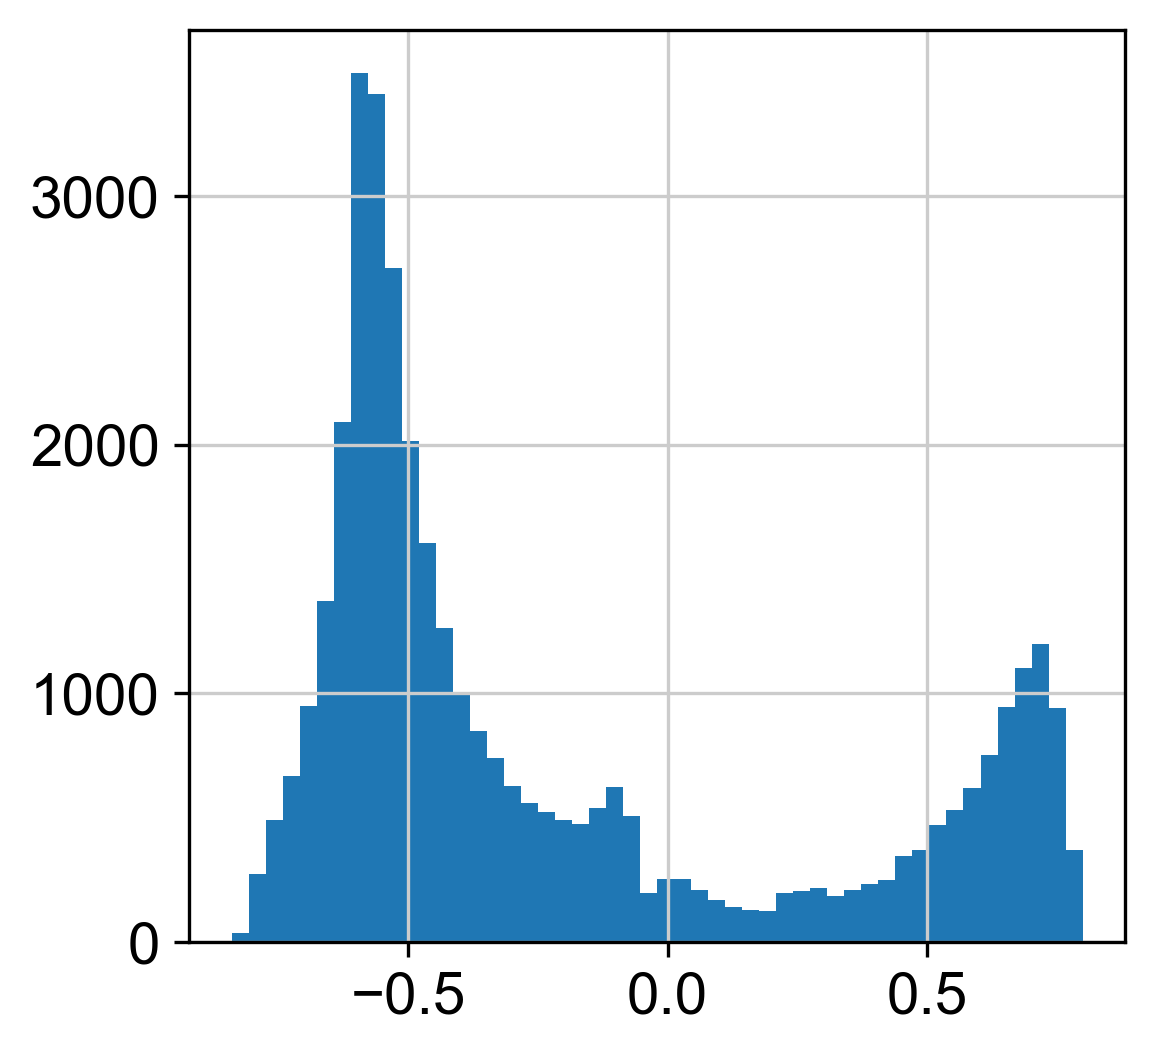

In [18]:
adata_paed_cma.obs['manual_bin_cma_v2'] = adata_paed_cma.obs['manual_bin_cma_v2'].cat.reorder_categories(ct_order)
adata_paed_cma.obs['manual_bin_cma_v2'].value_counts()
adata_paed_cma.obs['cma_v2'].hist(bins=50)
plt.show()

# Analyse cell level

In [19]:
celltypes = adata_paed_cma.uns['mod']['factor_names']
cellab_paed = sc.AnnData(adata_paed_cma.obs[celltypes], 
                         obs = adata_paed_cma.obs.drop(celltypes, axis = 1),obsm = adata_paed_cma.obsm)

cellab_paed.var_names
sc.pp.normalize_total(cellab_paed,target_sum=100)


Index(['B-memory', 'B-naive', 'B-plasma', 'DC1', 'DC2', 'EC-Art', 'EC-Art-ELN',
       'EC-Cap', 'EC-Lymphatic', 'EC-Ven', 'InterloFb', 'Macrophage-APOC2',
       'Macrophage-SPIC1', 'Monocyte_IL1B', 'Myelocyte', 'Neutrophil',
       'Pericyte', 'Pericyte_CCL19', 'Pericyte_COL1A1', 'PeriloFb', 'SMC',
       'TEC-cilliated', 'TEC-myo', 'TEC-neuro', 'T_CD4', 'T_CD8',
       'T_CD8_memory', 'T_CD8αα(I)', 'T_CD8αα(II)', 'T_CD8αα(entry)',
       'T_DN(P)', 'T_DN(Q)', 'T_DN(early)', 'T_DP(P)', 'T_DP(Q)',
       'T_DP(Q)-CD99', 'T_DP(Q)-early', 'T_DP(Q)-late_vdj', 'T_ETP', 'T_NK',
       'T_Treg(agonist)', 'T_Treg-diff_1', 'T_Treg-diff_2', 'T_Treg_CD8',
       'T_Treg_mature', 'T_Treg_recirc', 'T_αβT(entry)', 'T_γδT', 'aDC1',
       'aDC2', 'aDC3', 'cTECI', 'cTECII', 'cTECIII', 'mTECI', 'mTECI-Prolif',
       'mTECI-trans', 'mTECII', 'mTECIII', 'mcTEC_cTECI-primed',
       'mcTEC_mTECI-primed', 'mcTEC_unprimed', 'medFB-MHCIIh', 'medFb',
       'medFb-RGS5', 'pDC'],
      dtype='object')

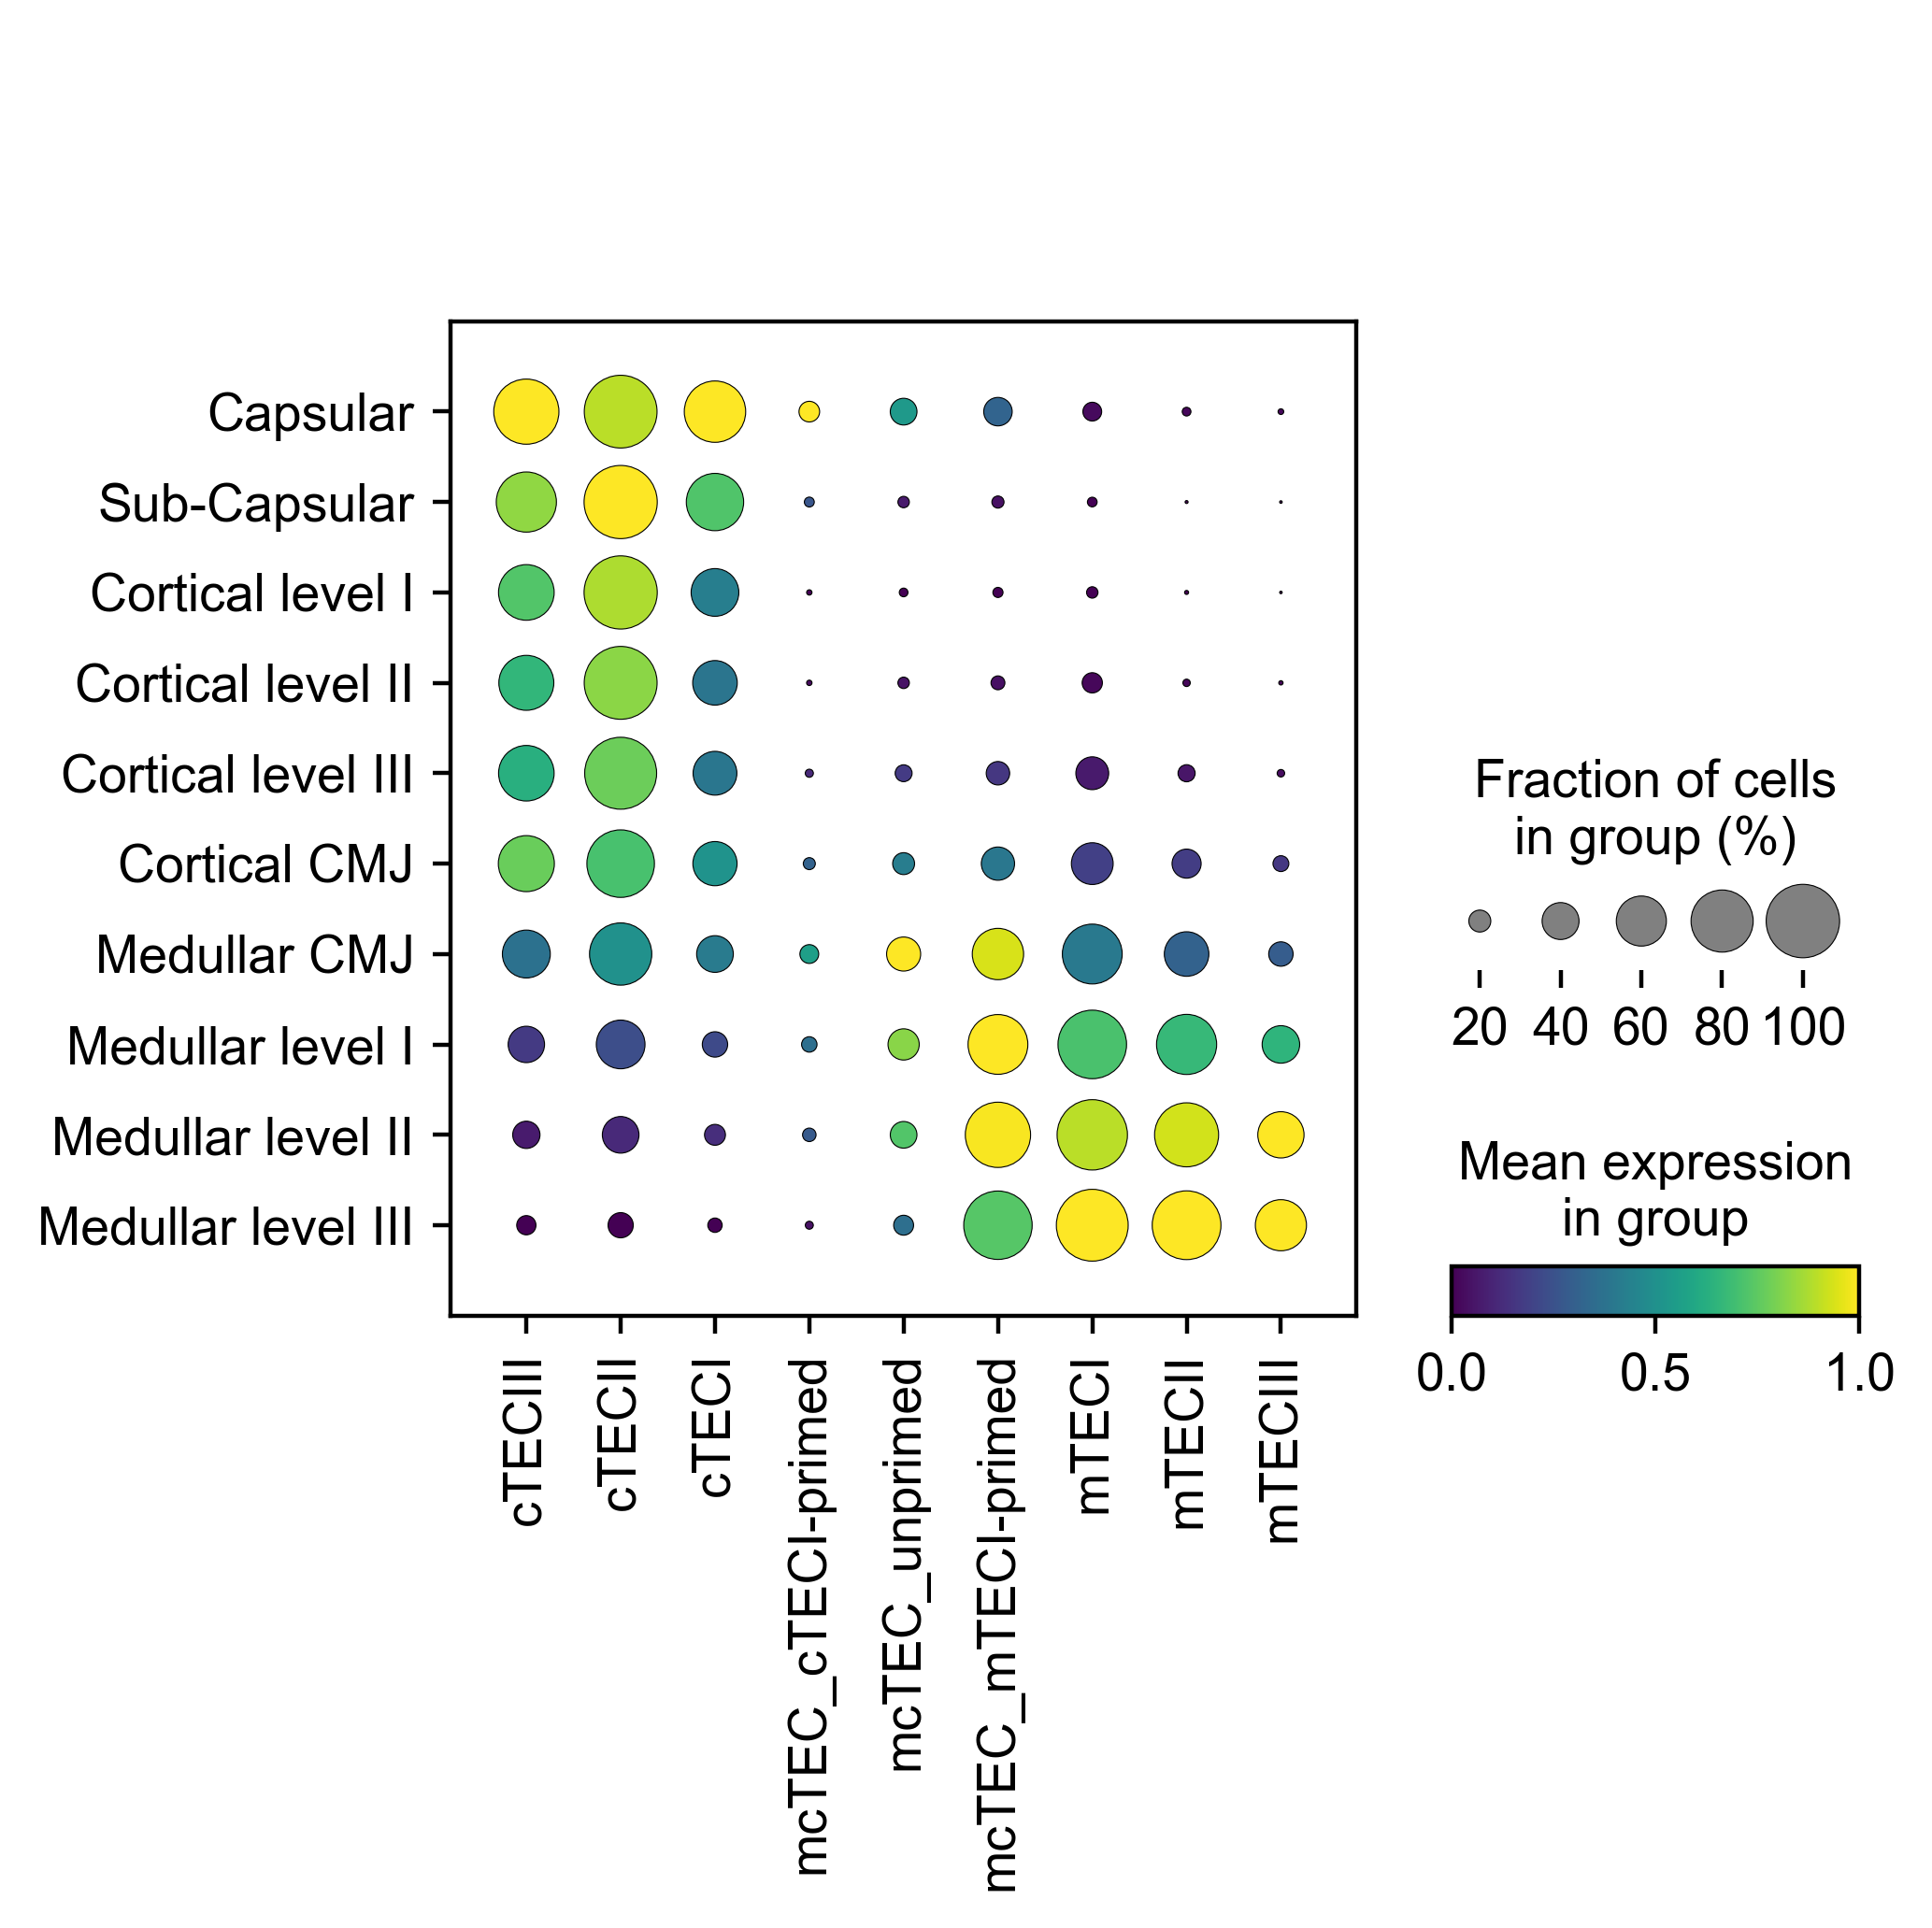

In [23]:
cells = ['cTECIII','cTECII','cTECI','mcTEC_cTECI-primed', 'mcTEC_unprimed',
       'mcTEC_mTECI-primed', 'mTECI','mTECII','mTECIII']

cutoff = 0.25

sc.set_figure_params(figsize=[7,7],fontsize=12,dpi=200)
sc.pl.dotplot(cellab_paed,var_names=cells,
               groupby='manual_bin_cma_v2',cmap='viridis',standard_scale='var',expression_cutoff=cutoff,save='paed_tec_cutoff'+str(cutoff)+'_full_context.pdf')
      
    